In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(hash)
library(RColorBrewer)
library(patchwork)
library(gridExtra)
library(clusterProfiler)
library(ggthemes)
library(ggpubr)
library(org.Mm.eg.db)
library(MAST)
date()

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


hash-2.2.6.2 provided by Decision Patterns



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




clusterProfiler v4.6.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’



[1] "Mon Jul 10 03:19:00 2023"

## Function ##

### DEG_Voclcano #

In [2]:
# DEG_Voclcano #
DEG_Volcano <- function(markers,algorithm,output,celltype,title,logfc = 0.5,INF = 300){
  markers$logP[is.infinite(markers$logP)] <- INF
  pdf(paste0(output,"/",algorithm,"_",celltype,".",title,".pdf",sep=""),width = 9,height = 6)
  p <- ggscatter(markers,x="avg_log2FC",y="logP",color = "group",palette = c("#2f5688","#BBBBBB","#CC0000"),
                 size=0.5 ,label = markers$Label, font.label = 8 ,repel = T, xlab = "avg_log2FoldChange",
                 ylab = "-log10(Adjusted P-value)",title = paste(title,":",celltype,sep = "")) +
    theme_base()+ scale_x_continuous(limits = c(min(markers$avg_log2FC)-0.5, max(markers$avg_log2FC)+0.5)) +
    scale_y_continuous(limits = c(-2,max(markers$logP)+20))+
    geom_hline(yintercept = 1.30, linetype="dashed")+
    geom_vline(xintercept = c(-logfc,logfc), linetype="dashed")+theme(plot.title=element_text(hjust=0.5))
  print(p)
  print(max(markers$logP))
  print(c(min(markers$avg_log2FC),max(markers$avg_log2FC)))
  dev.off()
}
DEG_Analyze <- function(celltypes,data,assay,algorithm,ident1,ident2,group,logfc,path,pval,title){
  dat <- data.frame()
  for (i in unique(celltypes)){
    print(i)
    markers <- FindMarkers(data,assay = assay,slot = "data",test.use = algorithm,ident.1 = ident1,
                           ident.2 = ident2,group.by = group,subset.ident = i,
                           logfc.threshold = 0) # logfc.threshold = 0 no filter
    markers$gene <- row.names(markers)
    markers$logP <- -log10(markers$p_val_adj)

    markers$group="not-significant"
    markers$group[which( (markers$p_val_adj < pval) & (markers$avg_log2FC > logfc ) )] = "up-regulated"
    markers$group[which( (markers$p_val_adj < pval) & (markers$avg_log2FC < -logfc ) )] = "down-regulated"

    markers$Label = ""
    markers <- markers[order(markers$p_val_adj),]
    up.genes <-head(markers$gene[which(markers$group == "up-regulated")],30)
    down.genes <-head(markers$gene[which(markers$group == "down-regulated")],30)
    markers.top30<-c(as.character(up.genes), as.character((down.genes)))
    markers$Label[match(markers.top30, markers$gene)] <- markers.top30
    markers.top30<-c(as.character(up.genes), as.character((down.genes)))
    markers$Label[match(markers.top30, markers$gene)] <- markers.top30
    markers$celltypes <- i
    write.table(markers,paste0(path,"/",algorithm,"_",i,"_GF_vs_SPF.txt",sep=""),sep='\t',quote=FALSE)
    DEG_Volcano(markers = markers,algorithm = algorithm , output = path ,celltype = i, title = title , logfc = logfc)
    dat <- rbind(dat,markers)
  }
  return(dat)
}
date()

[1] "Mon Jul 10 03:19:00 2023"

### DEG_simplify_GO #

In [3]:
DEG_simplify_GO <- function(sce.markers,padj,log2FC,go_organism){
  EnrichGeneGo <- function(gene_set){
    Go_anno <- enrichGO(gene_set, OrgDb = go_organism, ont='BP',pAdjustMethod = 'BH',
                        pvalueCutoff = 0.05, qvalueCutoff = 0.2, keyType = 'ENTREZID')
    Go_anno <- setReadable(Go_anno,OrgDb = go_organism,keyType = "ENTREZID") # lwm
    #Go_anno <- as.data.frame(Go_anno) # function ‘simplify’ for signature ‘"data.frame"’
    return(Go_anno)
  }
  ids = bitr(sce.markers$gene, fromType="SYMBOL", toType="ENTREZID", OrgDb=go_organism)
  sce.markers = merge(sce.markers, ids, by.x='gene', by.y='SYMBOL')
  sce.markers <- sce.markers[which((sce.markers$p_val_adj < padj) & 
                                   ((sce.markers$avg_log2FC > log2FC ) | (sce.markers$avg_log2FC < -log2FC ))),]
  sce.markers$group <- factor(ifelse(sce.markers$avg_log2FC < 0, -1, 1), levels = c(-1, 1))
  up_genes <- subset(sce.markers, group== 1)$ENTREZID
  down_genes <- subset(sce.markers, group== -1)$ENTREZID
  #print(length(up_genes)) # 2022-11-30
  #print(length(down_genes)) # 2022-11-30
  up_GO <- EnrichGeneGo(gene_set=up_genes) %>% dplyr::mutate(group=rep("1", n())) %>% 
    dplyr::mutate(mice = rep("GF",n()))
  down_GO <- EnrichGeneGo(gene_set=down_genes) %>% dplyr::mutate(group=rep("-1", n())) %>%
    dplyr::mutate(mice = rep("SPF",n()))
  # simplify # function ‘simplify’ for signature ‘"data.frame"’ 
  up_GO2 <- as.data.frame(simplify(up_GO, cutoff=0.7, by="p.adjust", select_fun=min)) 
  down_GO2 <- as.data.frame(simplify(down_GO, cutoff=0.7, by="p.adjust", select_fun=min))
  dat <- rbind(up_GO2, down_GO2)
  return(dat)
}
AllDEG_GOEnrichment <- function(marker,var,padj,log2FC,go_organism,prefix,output){
        Ndata <- data.frame()
        feature <- as.character(unique(marker[,var]))
        print(feature)
        for(i in 1:length(unique(feature))){
                print(i)
                print(feature[i])
                try({
                        data <- marker[marker[,var] == feature[i],]
                        #print(unique(data[,var]))
                        GO <- DEG_simplify_GO(data,padj = padj,log2FC = log2FC,go_organism = go_organism)
                        write.table(GO,file = paste(output,"/",prefix,"_",feature[i],"_simplify_GO.txt",sep = ""),
                                    sep = "\t",quote = F)
                        GO[,var] <- feature[i]
                        print(head(GO))
                        Ndata <- rbind(Ndata,GO)
                })
        }
        return(Ndata)
}
date()

[1] "Mon Jul 10 03:19:00 2023"

## cecum ## all celltypes DEG #

In [15]:
cecum <- readRDS('/data/work/FinallyPlot/SampleRDS/cecum/cecum_final_annotation.rds')
date()

[1] "Tue Jul  4 12:40:44 2023"

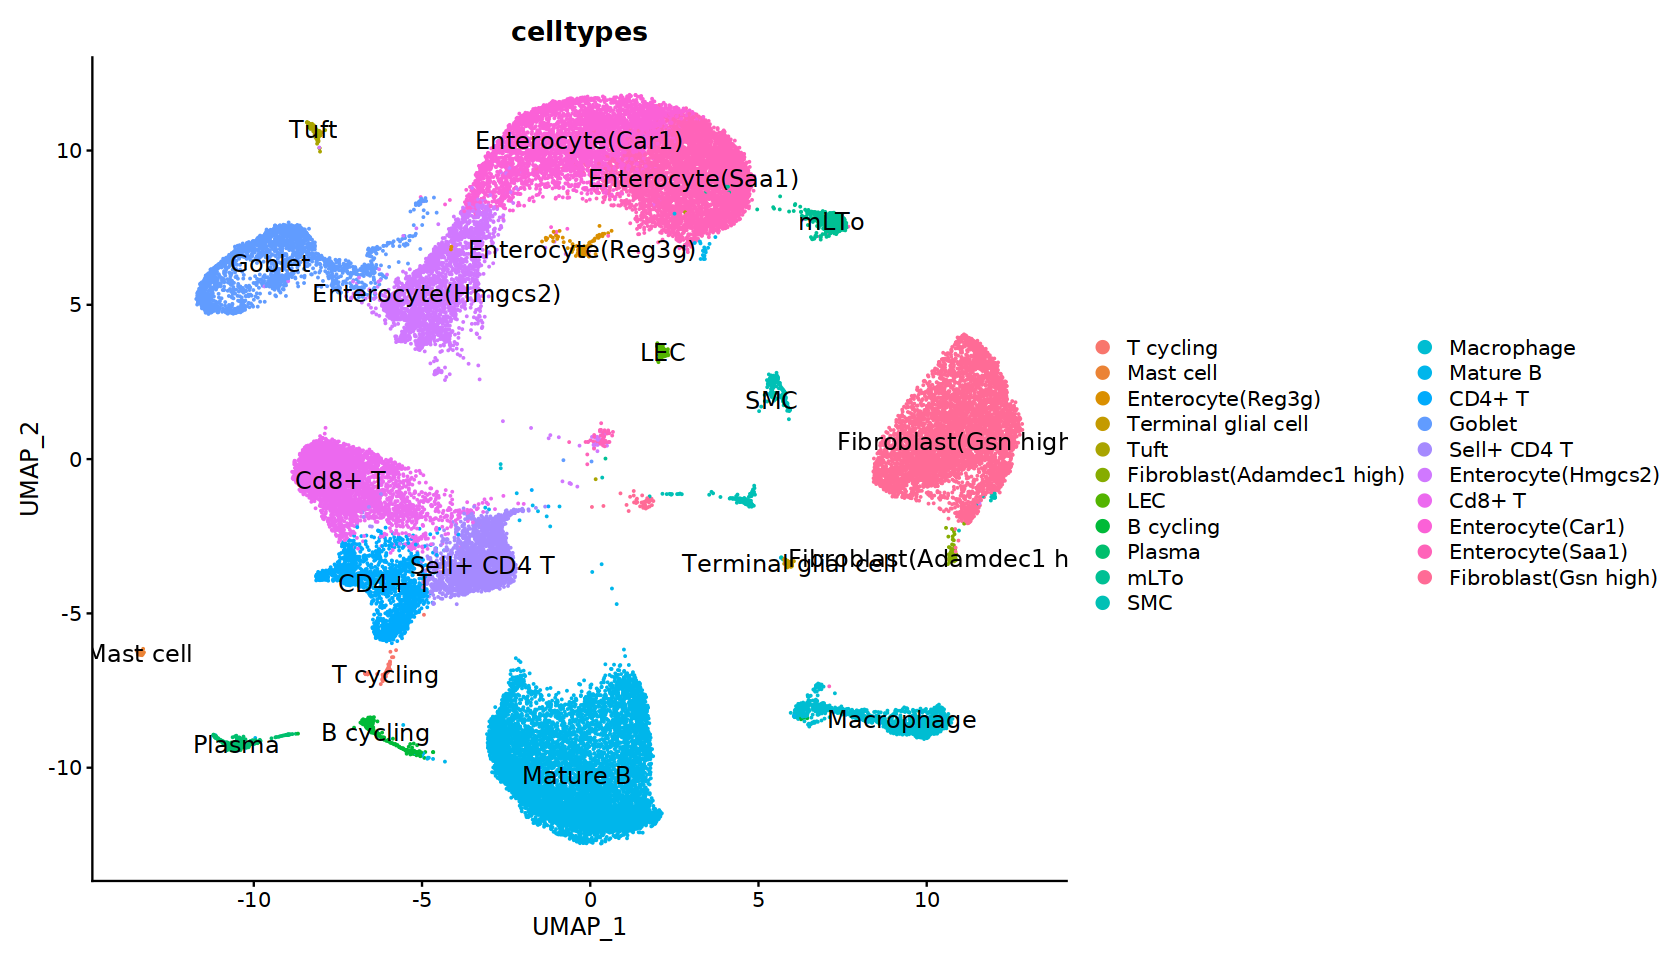

In [16]:
options(repr.plot.width = 14,repr.plot.height= 8)
p5 <- DimPlot(cecum,reduction = "umap",group.by = "celltypes",label = T,label.size = 5)
print(p5)

In [17]:
table(cecum@meta.data$celltypes,cecum@meta.data$mice)

                           
                              GF  SPF
  T cycling                    2   64
  Mast cell                   61   25
  Enterocyte(Reg3g)            0  116
  Terminal glial cell        112   14
  Tuft                       165    8
  Fibroblast(Adamdec1 high)  167   12
  LEC                        171   16
  B cycling                    6  271
  Plasma                      36  274
  mLTo                       375   62
  SMC                        398  112
  Macrophage                1131  334
  Mature B                  1174 7950
  CD4+ T                     685 1231
  Goblet                    1650  586
  Sell+ CD4 T                348 2068
  Enterocyte(Hmgcs2)        2124  599
  Cd8+ T                    1948 1850
  Enterocyte(Car1)          3778  593
  Enterocyte(Saa1)          4799  432
  Fibroblast(Gsn high)      5040  585

In [22]:
celltype <- as.character(unique(cecum@meta.data$celltypes))
print(celltype)

 [1] "Fibroblast(Gsn high)"      "CD4+ T"                   
 [3] "Cd8+ T"                    "Enterocyte(Saa1)"         
 [5] "Enterocyte(Car1)"          "Goblet"                   
 [7] "Macrophage"                "Enterocyte(Hmgcs2)"       
 [9] "SMC"                       "Mature B"                 
[11] "Terminal glial cell"       "LEC"                      
[13] "Sell+ CD4 T"               "Tuft"                     
[15] "Plasma"                    "mLTo"                     
[17] "Fibroblast(Adamdec1 high)" "Mast cell"                
[19] "B cycling"                 "T cycling"                
[21] "Enterocyte(Reg3g)"        


In [23]:
celltype <- celltype[1:19]
print(celltype)

 [1] "Fibroblast(Gsn high)"      "CD4+ T"                   
 [3] "Cd8+ T"                    "Enterocyte(Saa1)"         
 [5] "Enterocyte(Car1)"          "Goblet"                   
 [7] "Macrophage"                "Enterocyte(Hmgcs2)"       
 [9] "SMC"                       "Mature B"                 
[11] "Terminal glial cell"       "LEC"                      
[13] "Sell+ CD4 T"               "Tuft"                     
[15] "Plasma"                    "mLTo"                     
[17] "Fibroblast(Adamdec1 high)" "Mast cell"                
[19] "B cycling"                


In [24]:
prefix <- "cecum"
assay <- "RNA"
algorithm <- "MAST"
ident1 <- "GF"
ident2 <- "SPF"
group <- "mice"
log2fc <- 0.5
out <- "/data/work/FinallyPlot/SampleRDS/cecum/DEG"
padj <- 0.05
title <- "GF_vs_SPF"
date()

[1] "Tue Jul  4 12:57:08 2023"

In [ ]:
Idents(cecum) <- "celltypes"
All_DEG <- DEG_Analyze(celltype = celltype, data = cecum, assay = assay,algorithm = algorithm,
       ident1 = ident1, ident2 = ident2, group = group,logfc = log2fc,
       path = out,pval = padj, title = title)
date()

In [26]:
write.table(All_DEG,file = paste(out,"/",prefix,"_all_DEG.txt",sep =""),quote = F,row.names = F,sep = "\t")
date()

[1] "Tue Jul  4 13:53:14 2023"

In [ ]:
padj = 0.05
log2fc = 0.5
OrgDb = "org.Mm.eg.db"
prefix = "cecum"
output = "/data/work/FinallyPlot/SampleRDS/cecum/DEG"
date()

In [ ]:
NDEG <- AllDEG_GOEnrichment(marker = All_DEG,var = "celltypes",padj = padj, log2FC = log2fc, go_organism = OrgDb,
                             prefix = prefix, output = output)
date()

In [29]:
write.table(NDEG,file = paste(output,"/",prefix,"_DEG_ALL_GO.txt",sep =""),sep = "\t",quote = F)
date()

[1] "Tue Jul  4 14:12:29 2023"